In [1]:
import os
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report, accuracy_score
from PIL import Image
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras import layers, models
from tensorflow.keras.models import Model


In [2]:
# --- Step 1: Load image paths and labels ---
base_dir = '/kaggle/input/lungmri/LaoPhoi'
categories = ['Cobenh','Khongbenh']
image_paths = []
labels = []
for category in categories:
    category_path = os.path.join(base_dir, category)
    for filename in os.listdir(category_path):
        if filename.endswith('.jpg') or filename.endswith('.png'):
            image_paths.append(os.path.join(category_path, filename))
            labels.append(category)


In [3]:
# Create train-test split  
X_train, X_test, y_train, y_test = train_test_split(  
    image_paths,  
    labels,  
    test_size=0.2,  # 20% of data will be used as test set  
    random_state=42,  # For reproducibility 
) 
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
y_train = label_encoder.fit_transform(y_train)  # Encoding train labels
y_test = label_encoder.transform(y_test)  # Encoding test labels


**Thực hiện phân loại ảnh**

In [4]:
import numpy as np
import os
import cv2
import matplotlib.pyplot as plt

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Epoch 1/8
17/17 ━━━━━━━━━━━━━━━━━━━━ 26s 833ms/step - accuracy: 0.6051 - loss: 0.8277 - val_accuracy: 0.8222 - val_loss: 0.4424
Epoch 2/8
17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 99ms/step - accuracy: 0.7603 - loss: 0.5391 - val_accuracy: 0.8444 - val_loss: 0.4063
Epoch 3/8
17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 100ms/step - accuracy: 0.7865 - loss: 0.4515 - val_accuracy: 0.8519 - val_loss: 0.3666
Epoch 4/8
17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 100ms/step - accuracy: 0.8542 - loss: 0.3871 - val_accuracy: 0.8667 - val_loss: 0.3728
Epoch 5/8
17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 100ms/step - accuracy: 0.8492 - loss: 0.3502 - val_accuracy: 0.8815 - val_loss: 0.3475
Epoch 6/8
17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 98ms/step - accuracy: 0.8561 - loss: 0.3734 - val_accuracy: 0.8815 - val_loss: 0.3596
Epoch 7/8
17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 99ms/step - accuracy: 0.8695 - loss: 0.3404 - val_accuracy: 0.8370 - val_loss: 0.3929
Epoch 8/8
17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 100ms/step - accuracy:

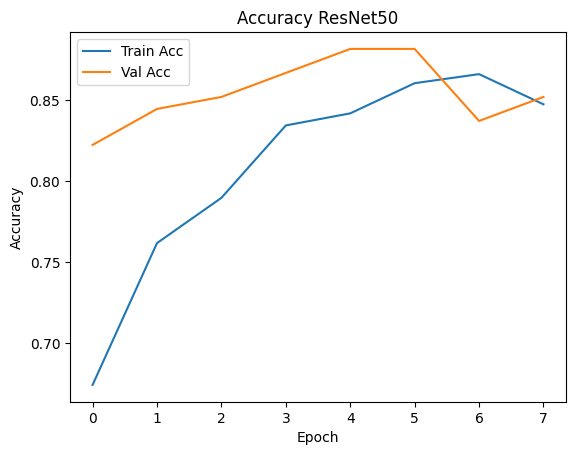

In [5]:

# Step 1: Hàm đọc và resize ảnh + chuẩn hóa theo chuẩn ResNet50
def load_images_resnet(image_paths, target_size=(224, 224)):
    images = []
    for path in image_paths:
        img = cv2.imread(path)
        img = cv2.resize(img, target_size)
        img = preprocess_input(img)  # Dùng hàm chuẩn hóa từ ResNet
        images.append(img)
    return np.array(images)

# Step 2: Create train-test split  
X_train, X_test, y_train, y_test = train_test_split(  
    image_paths,  
    labels,  
    test_size=0.2,  # 20% of data will be used as test set  
    random_state=42,  # For reproducibility 
) 

# Step 3:
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
y_train = label_encoder.fit_transform(y_train)  # Encoding train labels
y_test = label_encoder.transform(y_test)  # Encoding test labels

# Step 4: Convert to categorical (one-hot encoding)
num_classes = len(label_encoder.classes_)
y_train = to_categorical(y_train, num_classes)
y_test = to_categorical(y_test, num_classes)

# Step 5: Áp dụng cho train/test
x_train = load_images_resnet(X_train)
x_test = load_images_resnet(X_test)

# --- Step 6: Build ResNet50 model ---
# Load ResNet50 pre-trained, không bao gồm lớp output gốc
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model.trainable = False  # Không cho học lại trọng số gốc

# Thêm các lớp phía trên (custom head)
x = base_model.output
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(128, activation='relu')(x)
x = layers.Dropout(0.3)(x)  # Giảm overfitting
predictions = layers.Dense(num_classes, activation='softmax')(x)

# Gộp thành model hoàn chỉnh
model = Model(inputs=base_model.input, outputs=predictions)

# Compile model
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

#model.summary()

# --- Step 7: Train the model ---
history = model.fit(x_train, y_train, epochs=8, validation_data=(x_test, y_test))

# --- Step 8: Evaluate the model ---
test_loss, test_acc = model.evaluate(x_test, y_test)
print(f"\n🎯 Test Accuracy ResNet50: {test_acc:.4f}")

# Step 9: Vẽ biểu đồ training/validation accuracy
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy ResNet50')
plt.legend()
plt.savefig('ResNet50_train.png')
plt.show()


5/5 ━━━━━━━━━━━━━━━━━━━━ 7s 865ms/step


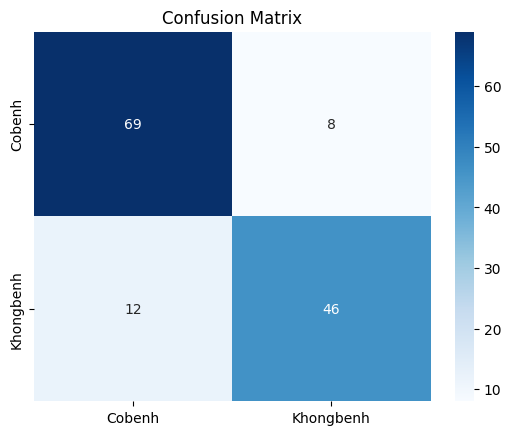

              precision    recall  f1-score   support

      Cobenh       0.85      0.90      0.87        77
   Khongbenh       0.85      0.79      0.82        58

    accuracy                           0.85       135
   macro avg       0.85      0.84      0.85       135
weighted avg       0.85      0.85      0.85       135



In [6]:
import seaborn as sns
# Step 1: Predict on the test set
y_pred_probs = model.predict(x_test)
y_pred_classes = np.argmax(y_pred_probs, axis=1)
y_true_classes = np.argmax(y_test, axis=1)

# Step 2: Create the confusion matrix
cm = confusion_matrix(y_true_classes, y_pred_classes)

# Step 3: Plot the confusion matrix
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=categories, yticklabels=categories)
plt.title('Confusion Matrix')
plt.title("Confusion Matrix")
plt.savefig('Proposed_Confusion.png')
plt.show()


# Báo cáo phân loại
print(classification_report(y_true_classes, y_pred_classes, target_names=label_encoder.classes_))


DenseNet

29084464/29084464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Epoch 1/8
17/17 ━━━━━━━━━━━━━━━━━━━━ 57s 2s/step - accuracy: 0.5185 - loss: 1.3848 - val_accuracy: 0.7630 - val_loss: 0.5073
Epoch 2/8
17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 103ms/step - accuracy: 0.6970 - loss: 0.6155 - val_accuracy: 0.8000 - val_loss: 0.4786
Epoch 3/8
17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 105ms/step - accuracy: 0.7705 - loss: 0.4707 - val_accuracy: 0.8444 - val_loss: 0.4310
Epoch 4/8
17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 102ms/step - accuracy: 0.8408 - loss: 0.3991 - val_accuracy: 0.8148 - val_loss: 0.4203
Epoch 5/8
17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 104ms/step - accuracy: 0.7985 - loss: 0.4433 - val_accuracy: 0.8296 - val_loss: 0.3971
Epoch 6/8
17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 103ms/step - accuracy: 0.8164 - loss: 0.4142 - val_accuracy: 0.8222 - val_loss: 0.3844
Epoch 7/8
17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 104ms/step - accuracy: 0.8575 - loss: 0.3854 - val_accuracy: 0.8296 - val_loss: 0.3910
Epoch 8/8
17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 106ms/step - accuracy:

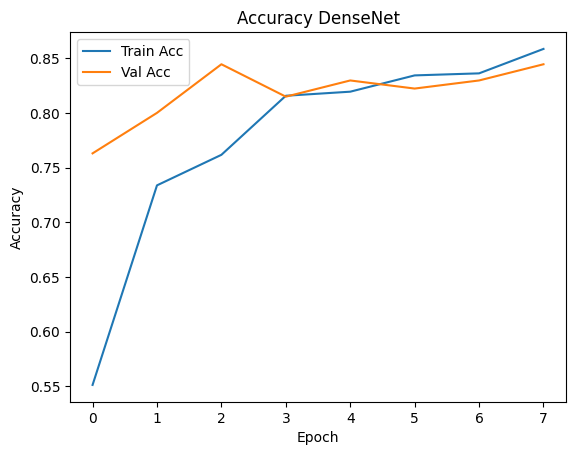

In [7]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.applications.densenet import preprocess_input  # đổi chuẩn hóa theo DenseNet
from tensorflow.keras import layers, Model
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

# Step 1: Hàm đọc và resize ảnh + chuẩn hóa theo DenseNet
def load_images_densenet(image_paths, target_size=(224, 224)):
    images = []
    for path in image_paths:
        img = cv2.imread(path)
        img = cv2.resize(img, target_size)
        img = preprocess_input(img)  # Dùng hàm chuẩn hóa của DenseNet
        images.append(img)
    return np.array(images)

# Step 2: Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    image_paths,
    labels,
    test_size=0.2,
    random_state=42,
)

# Step 3: Encode labels
label_encoder = LabelEncoder()
y_train = label_encoder.fit_transform(y_train)
y_test = label_encoder.transform(y_test)

# Step 4: One-hot encoding
num_classes = len(label_encoder.classes_)
y_train = to_categorical(y_train, num_classes)
y_test = to_categorical(y_test, num_classes)

# Step 5: Load và chuẩn hóa ảnh
x_train = load_images_densenet(X_train)
x_test = load_images_densenet(X_test)

# Step 6: Build DenseNet121 model
base_model = DenseNet121(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model.trainable = False  # Freeze pre-trained weights

x = base_model.output
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(128, activation='relu')(x)
x = layers.Dropout(0.3)(x)
predictions = layers.Dense(num_classes, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=predictions)

# Compile model
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Step 7: Train model
history = model.fit(x_train, y_train, epochs=8, validation_data=(x_test, y_test))

# Step 8: Evaluate
test_loss, test_acc = model.evaluate(x_test, y_test)
print(f"\n🎯 Test Accuracy DenseNet121: {test_acc:.4f}")

# Step 9: Vẽ biểu đồ training/validation accuracy
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy DenseNet')
plt.legend()
plt.savefig('DenseNet121_train.png')
plt.show()


5/5 ━━━━━━━━━━━━━━━━━━━━ 16s 2s/step


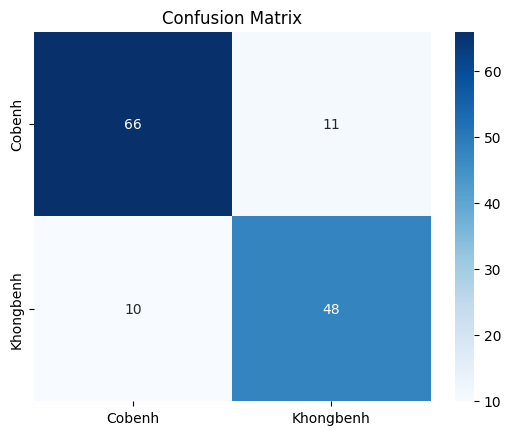

              precision    recall  f1-score   support

      Cobenh       0.87      0.86      0.86        77
   Khongbenh       0.81      0.83      0.82        58

    accuracy                           0.84       135
   macro avg       0.84      0.84      0.84       135
weighted avg       0.84      0.84      0.84       135



In [8]:
import seaborn as sns
# Step 1: Predict on the test set
y_pred_probs = model.predict(x_test)
y_pred_classes = np.argmax(y_pred_probs, axis=1)
y_true_classes = np.argmax(y_test, axis=1)

# Step 2: Create the confusion matrix
cm = confusion_matrix(y_true_classes, y_pred_classes)

# Step 3: Plot the confusion matrix
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=categories, yticklabels=categories)
plt.title('Confusion Matrix')
plt.title("Confusion Matrix")
plt.savefig('Proposed_Confusion.png')
plt.show()


# Báo cáo phân loại
print(classification_report(y_true_classes, y_pred_classes, target_names=label_encoder.classes_))


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/8
17/17 ━━━━━━━━━━━━━━━━━━━━ 17s 591ms/step - accuracy: 0.5278 - loss: 1.6688 - val_accuracy: 0.4296 - val_loss: 0.6824
Epoch 2/8
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 54ms/step - accuracy: 0.5965 - loss: 0.6669 - val_accuracy: 0.8444 - val_loss: 0.4172
Epoch 3/8
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 54ms/step - accuracy: 0.7875 - loss: 0.5202 - val_accuracy: 0.8222 - val_loss: 0.4325
Epoch 4/8
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 54ms/step - accuracy: 0.8046 - loss: 0.4761 - val_accuracy: 0.7852 - val_loss: 0.4288
Epoch 5/8
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 53ms/step - accuracy: 0.8603 - loss: 0.3869 - val_accuracy: 0.8296 - val_loss: 0.4207
Epoch 6/8
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 53ms/step - accuracy: 0.8423 - loss: 0.3796 - val_accuracy: 0.8000 - val_loss: 0.4524
Epoch 7/8
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 53ms/step - accuracy: 0.8606 - loss: 0.3881 - val_accuracy: 0.8148 - val_loss: 0.4361
Epoch 8/8
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 53ms/step - accuracy: 0.8385 - loss: 0.3744 - val_accuracy: 0.8074 - val_los

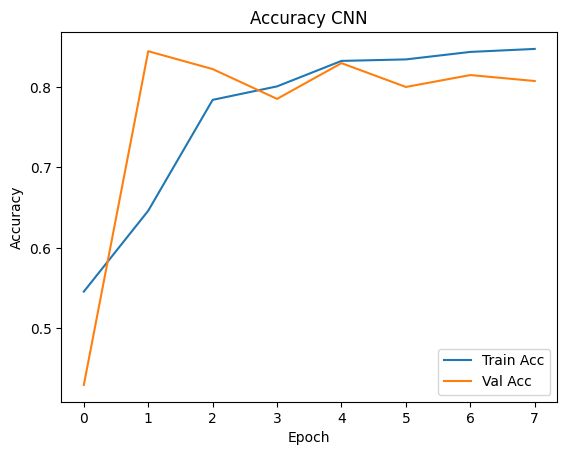

In [9]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras import layers, models
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

# Step 1: Hàm đọc và resize ảnh + chuẩn hóa (chia 255)
def load_images_cnn(image_paths, target_size=(224, 224)):
    images = []
    for path in image_paths:
        img = cv2.imread(path)
        img = cv2.resize(img, target_size)
        img = img / 255.0  # Normalize về [0,1]
        images.append(img)
    return np.array(images)

# Step 2: Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    image_paths,
    labels,
    test_size=0.2,
    random_state=42,
)

# Step 3: Encode labels
label_encoder = LabelEncoder()
y_train = label_encoder.fit_transform(y_train)
y_test = label_encoder.transform(y_test)

# Step 4: One-hot encoding
num_classes = len(label_encoder.classes_)
y_train = to_categorical(y_train, num_classes)
y_test = to_categorical(y_test, num_classes)

# Step 5: Load và chuẩn hóa ảnh
x_train = load_images_cnn(X_train)
x_test = load_images_cnn(X_test)

# Step 6: Build CNN model
model = models.Sequential()

# Conv Block 1
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)))
model.add(layers.MaxPooling2D((2, 2)))

# Conv Block 2
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))

# Conv Block 3
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))

# Flatten và Dense
model.add(layers.Flatten())
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dropout(0.3))
model.add(layers.Dense(num_classes, activation='softmax'))

# Compile model
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Step 7: Train model
history = model.fit(x_train, y_train, epochs=8, validation_data=(x_test, y_test))

# Step 8: Evaluate
test_loss, test_acc = model.evaluate(x_test, y_test)
print(f"\n🎯 Test Accuracy CNN: {test_acc:.4f}")

# Step 9: Vẽ biểu đồ training/validation accuracy
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy CNN')
plt.legend()
plt.savefig('CNN_train.png')
plt.show()


**ALexNet**

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 10s 309ms/step - accuracy: 0.5300 - loss: 4.4510 - val_accuracy: 0.5704 - val_loss: 0.6931
Epoch 2/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 56ms/step - accuracy: 0.5040 - loss: 0.6933 - val_accuracy: 0.4296 - val_loss: 0.6985
Epoch 3/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 52ms/step - accuracy: 0.5210 - loss: 0.6927 - val_accuracy: 0.4296 - val_loss: 0.6990
Epoch 4/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 52ms/step - accuracy: 0.5273 - loss: 0.6918 - val_accuracy: 0.4296 - val_loss: 0.7010
Epoch 5/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 52ms/step - accuracy: 0.5276 - loss: 0.6918 - val_accuracy: 0.4296 - val_loss: 0.6941
Epoch 6/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 52ms/step - accuracy: 0.4870 - loss: 0.6929 - val_accuracy: 0.4296 - val_loss: 0.6972
Epoch 7/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 52ms/step - accuracy: 0.5105 - loss: 0.6931 - val_accuracy: 0.4296 - val_loss: 0.6993
Epoch 8/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 52ms/step - accuracy: 0.4962 - loss: 0.6932 - val_accuracy: 0.4296 -

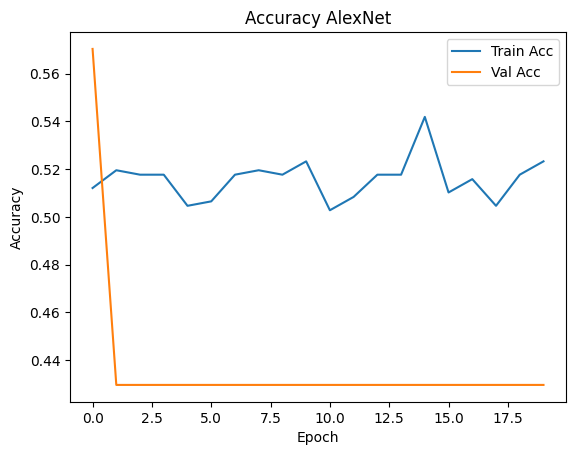

In [11]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras import layers, models
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

# Step 1: Hàm đọc và resize ảnh + chuẩn hóa (về [0,1])
def load_images_alexnet(image_paths, target_size=(224, 224)):
    images = []
    for path in image_paths:
        img = cv2.imread(path)
        img = cv2.resize(img, target_size)
        img = img / 255.0  # Normalize về [0,1]
        images.append(img)
    return np.array(images)

# Step 2: Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    image_paths,
    labels,
    test_size=0.2,
    random_state=42,
)

# Step 3: Encode labels
label_encoder = LabelEncoder()
y_train = label_encoder.fit_transform(y_train)
y_test = label_encoder.transform(y_test)

# Step 4: One-hot encoding
num_classes = len(label_encoder.classes_)
y_train = to_categorical(y_train, num_classes)
y_test = to_categorical(y_test, num_classes)

# Step 5: Load và chuẩn hóa ảnh
x_train = load_images_alexnet(X_train)
x_test = load_images_alexnet(X_test)

# Step 6: Build AlexNet model
model = models.Sequential()

# Conv Block 1
model.add(layers.Conv2D(96, (11, 11), strides=4, activation='relu', input_shape=(224, 224, 3)))
model.add(layers.MaxPooling2D((3, 3), strides=2))

# Conv Block 2
model.add(layers.Conv2D(256, (5, 5), padding='same', activation='relu'))
model.add(layers.MaxPooling2D((3, 3), strides=2))

# Conv Block 3
model.add(layers.Conv2D(384, (3, 3), padding='same', activation='relu'))

# Conv Block 4
model.add(layers.Conv2D(384, (3, 3), padding='same', activation='relu'))

# Conv Block 5
model.add(layers.Conv2D(256, (3, 3), padding='same', activation='relu'))
model.add(layers.MaxPooling2D((3, 3), strides=2))

# Flatten và Fully Connected Layers
model.add(layers.Flatten())
model.add(layers.Dense(4096, activation='relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(4096, activation='relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(num_classes, activation='softmax'))

# Compile model
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Step 7: Train model
history = model.fit(x_train, y_train, epochs=20, validation_data=(x_test, y_test))

# Step 8: Evaluate
test_loss, test_acc = model.evaluate(x_test, y_test)
print(f"\n🎯 Test Accuracy AlexNet: {test_acc:.4f}")

# Step 9: Vẽ biểu đồ training/validation accuracy
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy AlexNet')
plt.legend()
plt.savefig('AlexNet_train.png')
plt.show()


219055592/219055592 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step
Epoch 1/8
17/17 ━━━━━━━━━━━━━━━━━━━━ 85s 3s/step - accuracy: 0.6236 - loss: 0.8928 - val_accuracy: 0.7926 - val_loss: 0.4731
Epoch 2/8
17/17 ━━━━━━━━━━━━━━━━━━━━ 7s 417ms/step - accuracy: 0.7299 - loss: 0.5468 - val_accuracy: 0.7407 - val_loss: 0.5020
Epoch 3/8
17/17 ━━━━━━━━━━━━━━━━━━━━ 7s 428ms/step - accuracy: 0.7183 - loss: 0.5219 - val_accuracy: 0.7778 - val_loss: 0.4998
Epoch 4/8
17/17 ━━━━━━━━━━━━━━━━━━━━ 7s 433ms/step - accuracy: 0.7382 - loss: 0.5090 - val_accuracy: 0.7481 - val_loss: 0.4942
Epoch 5/8
17/17 ━━━━━━━━━━━━━━━━━━━━ 7s 422ms/step - accuracy: 0.7128 - loss: 0.5323 - val_accuracy: 0.7333 - val_loss: 0.5270
Epoch 6/8
17/17 ━━━━━━━━━━━━━━━━━━━━ 7s 415ms/step - accuracy: 0.7377 - loss: 0.5399 - val_accuracy: 0.7630 - val_loss: 0.4814
Epoch 7/8
17/17 ━━━━━━━━━━━━━━━━━━━━ 7s 410ms/step - accuracy: 0.7772 - loss: 0.4633 - val_accuracy: 0.7704 - val_loss: 0.4846
Epoch 8/8
17/17 ━━━━━━━━━━━━━━━━━━━━ 7s 406ms/step - accurac

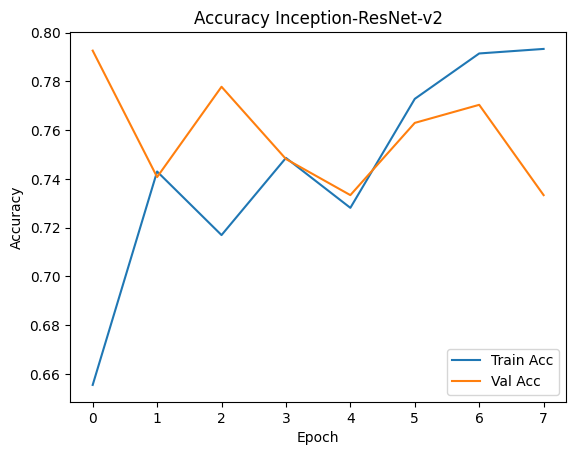

In [12]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras import layers, models
from tensorflow.keras.applications import InceptionResNetV2
from tensorflow.keras.applications.inception_resnet_v2 import preprocess_input
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.models import Model

# Step 1: Hàm đọc và resize ảnh + chuẩn hóa theo chuẩn Inception-ResNet-v2
def load_images_inception_resnet(image_paths, target_size=(299, 299)):
    images = []
    for path in image_paths:
        img = cv2.imread(path)
        img = cv2.resize(img, target_size)
        img = preprocess_input(img)  # Dùng chuẩn hóa chuẩn của InceptionResNetV2
        images.append(img)
    return np.array(images)

# Step 2: Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    image_paths,
    labels,
    test_size=0.2,
    random_state=42,
)

# Step 3: Encode labels
label_encoder = LabelEncoder()
y_train = label_encoder.fit_transform(y_train)
y_test = label_encoder.transform(y_test)

# Step 4: One-hot encoding
num_classes = len(label_encoder.classes_)
y_train = to_categorical(y_train, num_classes)
y_test = to_categorical(y_test, num_classes)

# Step 5: Load và chuẩn hóa ảnh
x_train = load_images_inception_resnet(X_train)
x_test = load_images_inception_resnet(X_test)

# Step 6: Build Inception-ResNet-v2 model
base_model = InceptionResNetV2(weights='imagenet', include_top=False, input_shape=(299, 299, 3))
base_model.trainable = False  # Freeze pre-trained weights

# Custom head
x = base_model.output
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(256, activation='relu')(x)
x = layers.Dropout(0.4)(x)
predictions = layers.Dense(num_classes, activation='softmax')(x)

# Model tổng thể
model = Model(inputs=base_model.input, outputs=predictions)

# Compile model
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Step 7: Train model
history = model.fit(x_train, y_train, epochs=8, validation_data=(x_test, y_test))

# Step 8: Evaluate
test_loss, test_acc = model.evaluate(x_test, y_test)
print(f"\n🎯 Test Accuracy Inception-ResNet-v2: {test_acc:.4f}")

# Step 9: Vẽ biểu đồ training/validation accuracy
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy Inception-ResNet-v2')
plt.legend()
plt.savefig('InceptionResNetV2_train.png')
plt.show()


5/5 ━━━━━━━━━━━━━━━━━━━━ 21s 3s/step 


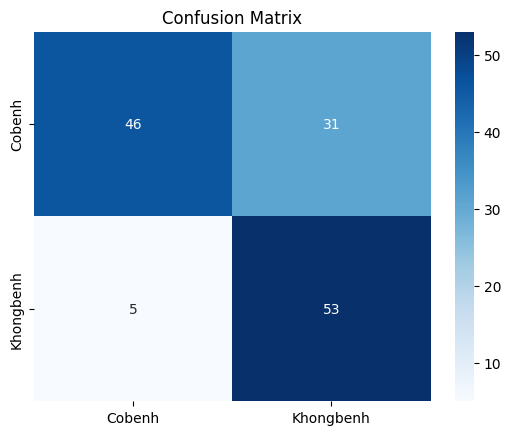

              precision    recall  f1-score   support

      Cobenh       0.90      0.60      0.72        77
   Khongbenh       0.63      0.91      0.75        58

    accuracy                           0.73       135
   macro avg       0.77      0.76      0.73       135
weighted avg       0.79      0.73      0.73       135



In [13]:
import seaborn as sns
# Step 1: Predict on the test set
y_pred_probs = model.predict(x_test)
y_pred_classes = np.argmax(y_pred_probs, axis=1)
y_true_classes = np.argmax(y_test, axis=1)

# Step 2: Create the confusion matrix
cm = confusion_matrix(y_true_classes, y_pred_classes)

# Step 3: Plot the confusion matrix
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=categories, yticklabels=categories)
plt.title('Confusion Matrix')
plt.title("Confusion Matrix")
plt.savefig('Proposed_Confusion.png')
plt.show()


# Báo cáo phân loại
print(classification_report(y_true_classes, y_pred_classes, target_names=label_encoder.classes_))
